# Data Challenge 2A : Employee Retention
## Surendra Walter Singaram

### Introduction

Employee turn-over is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months. It is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee
retention as well as planning new hiring in advance.

In this challenge, we will uncover the key drivers for employee churn by predicting when an employee is likely to terminate.  We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience. As said above, the goal is to predict employee retention and understand its main drivers.

We will assume for each company, that the headcount starts from zero on 2011/01/23. We will estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.

What are the main factors that drive employee churn? Do they make sense? Explain your
findings.
If you could add to this data set just one variable that could help explain employee churn,
what would that be? 

### Data

The data contains 35,000 entries about the employees: we know which company they work for, which department they work in, their average annual salary, how many years they've worked before starting thier current position, their start date and their termination date.  The data was collected over four years, from 2011/01/24 to 2015/12/13. (The termination date is 'NaN' for an employee still working for the company after the study ended). 

### My recommendations

To analyze employee retention, I used survival analysis based on the [Meir-Kaplan estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) and the [Cox's proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model).  I found 40% of employees leave after the first year, across all companies and departments; another drop in employment occurs, though less dramatic, after the second year; we should expect to see an increase in employee retention if we can hold on to employees during these tenuous moments.

The drivers for retention, average salary and seniority, depend on department.  For example, seniority in the data science department will lead to longer retention, but in the marketing department it will have the opposite effect.

Average salary is a misleading feature because an employee's salary will change over their tenure.  I could build a better model if I had the employee's salary over time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

### Data Cleaning

In [2]:
employee_data = pd.read_csv("./Data Challenge 2A/employee_retention.txt",index_col=0)

In [3]:
employee_data_copy = employee_data.copy()

In [4]:
employee_data_copy["join_date"] = pd.to_datetime(employee_data["join_date"])
employee_data_copy["quit_date"] = pd.to_datetime(employee_data["quit_date"])

In [5]:
employee_data_copy["length of employment (months)"] = employee_data_copy["quit_date"] - employee_data_copy["join_date"]

In [6]:
employee_data_copy["length of employment (months)"] = employee_data_copy["length of employment (months)"]/np.timedelta64(1,'M')

Some employees are missing salaries and many are still employed, leading to NaN values for length of employment

In [9]:
employee_data_copy.head(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length of employment (months),event
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25,2.956940,1
1,388804.0,8,design,21,191000.0,2011-05-17,2012-03-16,9.987885,1
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10,36.468921,1
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30,21.749933,1
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18,2.956940,1
5,287530.0,5,marketing,20,180000.0,2014-06-30,NaT,NaN,0
6,561043.0,3,customer_service,18,119000.0,2012-07-02,2014-03-28,20.829997,1
7,702479.0,7,data_science,7,140000.0,2011-12-27,2013-08-30,20.107189,1
8,545690.0,10,data_science,16,238000.0,2013-12-23,NaT,NaN,0
9,622587.0,5,sales,28,166000.0,2015-07-01,NaT,NaN,0


Let's censor the data by using the last day of the study as the termination date for employees that were employed when the study ended

In [8]:
#termination event occured before observation period ended == 1 (not censored)
#termination event did not occur before observation period ended == 0 (censored)
employee_data_copy["event"] = np.where(np.isnan(employee_data_copy["length of employment (months)"]),0,1) 

In [12]:
employee_data_copy["event_bool"] = employee_data_copy["event"].astype('bool')

In [10]:
employee_data_copy["quit_date"].fillna(datetime.datetime(2015,12,13),inplace=True)

Let's scale the salary down so that its values are on the same order of magnitude as other numeric data

In [11]:
employee_data_copy["salary"] = employee_data_copy["salary"]/10000.0

In [15]:
employee_data_copy.head(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length of employment (months),event,event_bool
0,1001444.0,8,temp_contractor,0,0.5850,2008-01-26,2008-04-25,2.956940,1,True
1,388804.0,8,design,21,19.1000,2011-05-17,2012-03-16,9.987885,1,True
2,407990.0,3,design,9,9.0000,2012-03-26,2015-04-10,36.468921,1,True
3,120657.0,2,engineer,20,29.8000,2013-04-08,2015-01-30,21.749933,1,True
4,1006393.0,1,temp_contractor,0,0.8509,2008-07-20,2008-10-18,2.956940,1,True
5,287530.0,5,marketing,20,18.0000,2014-06-30,2015-12-13,17.445943,0,False
6,561043.0,3,customer_service,18,11.9000,2012-07-02,2014-03-28,20.829997,1,True
7,702479.0,7,data_science,7,14.0000,2011-12-27,2013-08-30,20.107189,1,True
8,545690.0,10,data_science,16,23.8000,2013-12-23,2015-12-13,23.655517,0,False
9,622587.0,5,sales,28,16.6000,2015-07-01,2015-12-13,5.421056,0,False


In [14]:
employee_data_copy["length of employment (months)"] = employee_data_copy["quit_date"] - employee_data_copy["join_date"]
employee_data_copy["length of employment (months)"] = employee_data_copy["length of employment (months)"]/np.timedelta64(1,'M')

Let's have a look at the different types of employees

In [16]:
employee_data_temp_contractor = employee_data_copy[employee_data_copy.dept == 'temp_contractor']
employee_data_customer_service = employee_data_copy[employee_data_copy.dept == 'customer_service']
employee_data_engineer = employee_data_copy[employee_data_copy.dept == 'engineer']
employee_data_data_science = employee_data_copy[employee_data_copy.dept == 'data_science']
employee_data_sales = employee_data_copy[employee_data_copy.dept == 'sales']
employee_data_marketing = employee_data_copy[employee_data_copy.dept == 'marketing']
employee_data_design = employee_data_copy[employee_data_copy.dept == 'design']

Temporary contractors, although making up a third of the employees, only stay for 3 months so we will not include them in our analysis of employee retention, which is on the scale of years

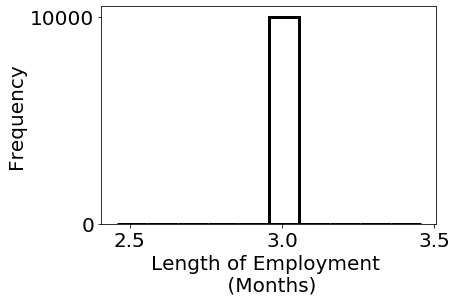

In [32]:
employee_data_temp_contractor["length of employment (months)"].hist(grid=False,facecolor='w',edgecolor='k',lw=3.0);
plt.xlabel("Length of Employment \n (Months)",fontsize=20);
plt.xticks([2.5, 3.0, 3.5],fontsize=20);
plt.yticks([0,10000],fontsize=20);
plt.ylabel('Frequency',fontsize=20);

In [33]:
pd.DataFrame({"job":["customer service","engineering","data science","sales","marketing","design"],"median salary":[employee_data_customer_service["salary"].median(),
employee_data_engineer["salary"].median(),employee_data_data_science["salary"].median(),employee_data_sales["salary"].median(),employee_data_marketing["salary"].median(),employee_data_design["salary"].median()]})

,job,median salary
0,customer service,8.3
1,engineering,20.9
2,data science,20.9
3,sales,13.7
4,marketing,13.8
5,design,13.9


In [34]:
employee_data_customer_service["salary"].fillna(8.3,inplace=True)
employee_data_engineer["salary"].fillna(20.9,inplace=True)
employee_data_data_science["salary"].fillna(20.9,inplace=True)
employee_data_sales["salary"].fillna(13.7,inplace=True)
employee_data_marketing["salary"].fillna(13.8,inplace=True)
employee_data_design["salary"].fillna(13.9,inplace=True)

/home/walter/software/anaconda3/envs/data_challenge_2/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Let's create the data frame we'll use for analyzing employee retention

In [37]:
employee_data_retention = pd.concat([employee_data_customer_service,employee_data_engineer,employee_data_data_science,employee_data_sales,employee_data_marketing,employee_data_design],ignore_index=True)

In [38]:
employee_data_retention = employee_data_retention.sample(frac=1).reset_index(drop=True)

Companies 11 and 12 only have 40 employees so we will ignore them in this analysis

In [39]:
employee_data["company_id"].value_counts()

1     9501
2     5220
3     3773
4     3066
5     2749
6     2258
7     2185
8     2026
9     2005
10    1879
12      24
11      16
Name: company_id, dtype: int64

### Computing the number of employees in each company

In [40]:
start = datetime.datetime(2011,1,23)
end = datetime.datetime(2015,12,13)
datearray = (start + datetime.timedelta(days=x) for x in range(0,(end-start).days))

Make a time series for every day between 2011/01/23 and 2015/12/13

In [41]:
headcount_template_df = pd.DataFrame(list(datearray))
headcount_template_df.rename(columns={0:"date"},inplace=True)
headcount_template_df.head()

,date
0,2011-01-23
1,2011-01-24
2,2011-01-25
3,2011-01-26
4,2011-01-27


I made a class to help me do some of the repetitive data wrangling steps.  It will create a table with three columns: the date, the number of employees employed by the company, and the company id

In [43]:
class Company:
    
    import pandas as pd
    
    def __init__(self, name,num, df,headcount_template):
        self.name = name
        self.num = num
        self.df = df[df.company_id == num]
        self.headcount = headcount_template
        self.headcount["head count"] = 0
        self.headcount["company id"] = num
        
        self.company_join = self.df["join_date"].value_counts().to_frame()
        self.company_join.reset_index(inplace=True)
        self.company_join.rename(columns={"index":"date","join_date":"num joined"},inplace=True)
        
        self.company_quit = self.df["quit_date"].value_counts().to_frame()
        self.company_quit.reset_index(inplace=True)
        self.company_quit.rename(columns={"index":"date","quit_date":"num quit"},inplace=True)
                                 
        self.headcount = pd.merge(self.headcount,self.company_join,how='left',on=['date'])
        self.headcount = pd.merge(self.headcount,self.company_quit,how='left',on=['date'])
                                 
        self.headcount.fillna(0,inplace=True)
        self.headcount["num add"] = self.headcount["num joined"] - self.headcount["num quit"]
        self.headcount["head count"] = self.headcount["num add"].cumsum()
        
        self.headcount.drop(columns=["num joined","num quit","num add"],inplace=True)

In [44]:
company_1 = Company("Company 1",1,employee_data_copy,headcount_template_df)
company_2 = Company("Company 2",2,employee_data_copy,headcount_template_df)
company_3 = Company("Company 3",3,employee_data_copy,headcount_template_df)
company_4 = Company("Company 4",4,employee_data_copy,headcount_template_df)
company_5 = Company("Company 5",5,employee_data_copy,headcount_template_df)
company_6 = Company("Company 6",6,employee_data_copy,headcount_template_df)
company_7 = Company("Company 7",7,employee_data_copy,headcount_template_df)
company_8 = Company("Company 8",8,employee_data_copy,headcount_template_df)
company_9 = Company("Company 9",9,employee_data_copy,headcount_template_df)
company_10 = Company("Company 10",10,employee_data_copy,headcount_template_df)

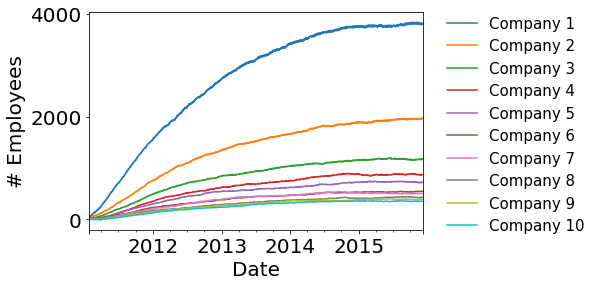

In [79]:
ax = plt.gca()
company_1.headcount.plot(kind='line',x='date',y='head count',label=company_1.name,ax=ax);
company_2.headcount.plot(kind='line',x='date',y='head count',label=company_2.name,ax=ax);
company_3.headcount.plot(kind='line',x='date',y='head count',label=company_3.name,ax=ax);
company_4.headcount.plot(kind='line',x='date',y='head count',label=company_4.name,ax=ax);
company_5.headcount.plot(kind='line',x='date',y='head count',label=company_5.name,ax=ax);
company_6.headcount.plot(kind='line',x='date',y='head count',label=company_6.name,ax=ax);
company_7.headcount.plot(kind='line',x='date',y='head count',label=company_7.name,ax=ax);
company_8.headcount.plot(kind='line',x='date',y='head count',label=company_8.name,ax=ax);
company_9.headcount.plot(kind='line',x='date',y='head count',label=company_9.name,ax=ax);
company_10.headcount.plot(kind='line',x='date',y='head count',label=company_10.name,ax=ax);
ax.legend(loc='upper right', bbox_to_anchor= (1.5, 1.01), ncol=1, 
            borderaxespad=0, frameon=False,fontsize=15);
ax.set_xlabel('Date',fontsize=20);
plt.xticks(fontsize=20);
ax.set_ylabel('# Employees',fontsize=20);
plt.yticks([0,2000,4000],fontsize=20);

Near the end of the study all the companies have reached a steady state!

### The main drivers for employee retention

In this section we will determine the main drivers for employee retention.  We will use survival analysis to calculate the probablility an employee will terminate -- this will be our measure for employee "churn".  Furthermore, the Meir-Kaplan model and its derivatives are well-suited to handle right-censored studies (i.e., studies that end before some employees terminate).

In [80]:
class Department:
    from sksurv.nonparametric import kaplan_meier_estimator
    def __init__(self, name,df):
        self.name = name
        self.df = df
        self.data_x = df[["seniority","salary"]]
        self.data_y = df[["event_bool","length of employment (months)"]].to_records(index=False,column_dtypes={"event_bool":'?',"length of employment (months)":'<f8'})
        self.times, self.employment_proba = kaplan_meier_estimator(df["event_bool"],df["length of employment (months)"])

In [82]:
from sksurv.nonparametric import kaplan_meier_estimator

The Meir-Kaplan model estimates the "survival" function, $\hat{S}(t)$, which is the probability an employee will be employed after time $t$.  The "hazard" function, $h(t)$, is related to the conditional probability of still be in employed a short time later, given employment at time $t$, $P(\text{employed in }[t,t+\delta t] |\text{employed after time }t) = \dfrac{P(\text{employed in }[t,t+\delta t]}{P(\text{employed after time t})} = -\dfrac{\hat{S}(t+\delta t) - \hat{S}(t)}{\hat{S}(t)}$.
More explicitly, $h(t)$ is the conditional probability density, so we divide both sides by $\delta t$ to get
$h(t) \approx \dfrac{-d \ln \hat{S}(t)}{dt}$ or equivalently, $\hat{S}(t) = \exp \int -h(t)dt$.

In [83]:
#temp_contractor = Department("Temp. Contractor", employee_data_temp_contractor)
cust_service = Department("Customer Service",employee_data_customer_service)
engineer = Department("Engineering",employee_data_engineer)
data_science = Department("Data Science",employee_data_data_science)
sales = Department("Sales", employee_data_sales)
marketing = Department("Marketing",employee_data_marketing)
design = Department("Design",employee_data_design)

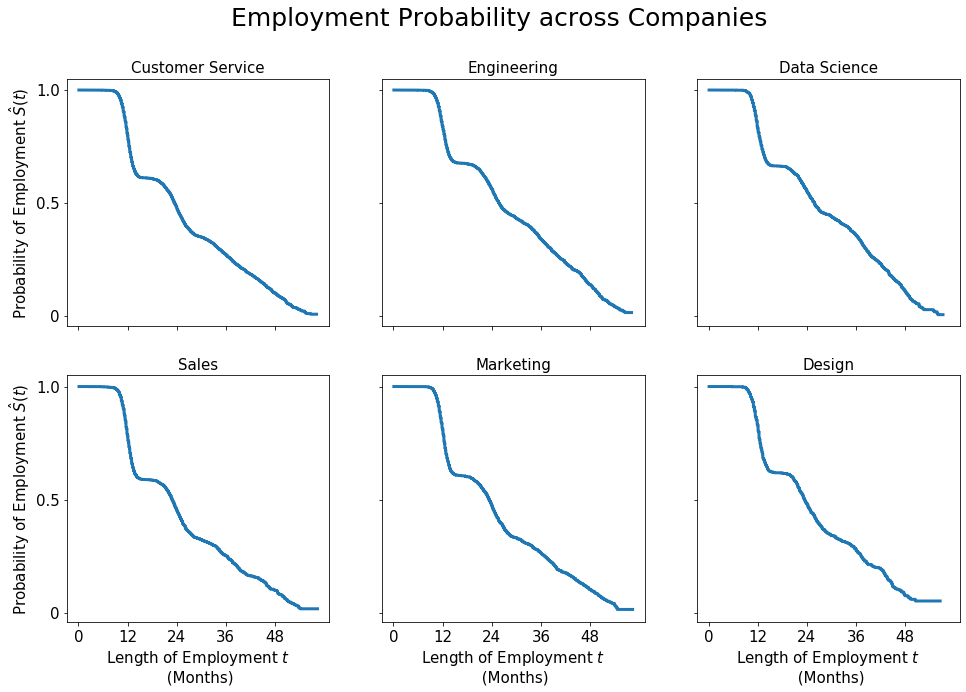

In [114]:
fig, axes = plt.subplots(2, 3,figsize=(16,10),sharex=True,sharey=True)
fig.suptitle("Employment Probability across Companies",fontsize=25)
axes[0,0].step(cust_service.times,cust_service.employment_proba,lw=3.0,where="post");
axes[0,0].set_title(cust_service.name,fontsize=15);
axes[0,0].set_ylabel('Probability of Employment $\hat{S}(t)$',fontsize=15)
axes[0,0].set_yticks([0.0,0.5,1.0])
axes[0,0].set_yticklabels([0,0.5,1.0],fontsize=15)
axes[0,1].step(engineer.times,engineer.employment_proba,lw=3.0,where="post");
axes[0,1].set_title(engineer.name,fontsize=15);
axes[0,2].step(data_science.times,data_science.employment_proba,lw=3.0,where="post");
axes[0,2].set_title(data_science.name,fontsize=15);
axes[1,0].step(sales.times,sales.employment_proba,lw=3.0,where="post");
axes[1,0].set_title(sales.name,fontsize=15);
axes[1,0].set_ylabel('Probability of Employment $\hat{S}(t)$',fontsize=15);
axes[1,0].set_xlabel('Length of Employment $t$ \n (Months)',fontsize=15);
axes[1,0].set_xticks([0,12,24,36,48])
axes[1,0].set_xticklabels([0,12,24,36,48],fontsize=15)
axes[1,0].set_yticks([0.0,0.5,1.0])
axes[1,0].set_yticklabels([0,0.5,1.0],fontsize=15)
axes[1,1].step(marketing.times,marketing.employment_proba,lw=3.0,where="post");
axes[1,1].set_xlabel('Length of Employment $t$ \n (Months)',fontsize=15);
axes[1,1].set_title(marketing.name,fontsize=15);
axes[1,1].set_xticks([0,12,24,36,48])
axes[1,1].set_xticklabels([0,12,24,36,48],fontsize=15)
axes[1,2].step(design.times,design.employment_proba,lw=3.0,where="post");
axes[1,2].set_title(design.name,fontsize=15);
axes[1,2].set_xlabel('Length of Employment $t$ \n (Months)',fontsize=15);
axes[1,2].set_xticks([0,12,24,36,48]);
axes[1,2].set_xticklabels([0,12,24,36,48],fontsize=15);

Biggest drop in employment happens after a year and the second biggest drop happens after two years.  This is across all departments!

In [117]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

Let us use the Cox's proportional hazard model to see if we can predict these survival curves; we'll use [Harrell's C-index](https://arxiv.org/pdf/1507.03092.pdf) judge how well our predictions do.  The C-index is similar to the AUCROC in that it lends itself to a probabilistic interpretation: it is the probability our model correctly orders a pair of survival times given their order.  Clearly, the worst the model can do is a 50-50 guess (i.e. C-index = 0.5).

In [118]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    coeffs = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
        coeffs[j] = m.coef_
    return scores, coeffs

**Customer service**

In [119]:
scores,coeffs = fit_and_score_features(cust_service.data_x.to_numpy(), cust_service.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=cust_service.data_x.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
salary,0.543382,0.046476
seniority,0.539156,0.014979


The coefficients are positive, so an increase in salary or an increase seniority or both will both increase the hazard function, increasing the probability that the employee terminates

**Engineer**

In [120]:
scores,coeffs = fit_and_score_features(engineer.data_x.to_numpy(), engineer.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=engineer.data_x.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
salary,0.580733,-0.025002
seniority,0.558697,-0.020476


The coefficients are opposite in sign; an increase in salary or an increase in seniority or both will, decrease the probability the employee terminates -- increasing employee retention!

**Data Scientist**

In [121]:
scores,coeffs = fit_and_score_features(data_science.data_x.to_numpy(), data_science.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=engineer.data_x.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
salary,0.570309,-0.023348
seniority,0.561697,-0.022492


An increase in salary or in seniority will increase employee retention of data scientists

**Sales**

In [123]:
scores,coeffs = fit_and_score_features(sales.data_x.to_numpy(), sales.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=sales.data_x.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
seniority,0.508638,0.001382
salary,0.506030,0.005323


Our model has no predictive power on employee retention in the sales department

**Marketing**

In [124]:
scores,coeffs = fit_and_score_features(marketing.data_x.to_numpy(), marketing.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=marketing.data_x.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
seniority,0.507547,0.004247
salary,0.503954,0.006519


Our model has no predictive power on employee retention in the marketing department

**Design**

In [125]:
scores,coeffs = fit_and_score_features(design.data_x.to_numpy(),design.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=design.data_x.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
seniority,0.523503,0.006290
salary,0.510477,0.010059


Our model has no predictive power on employee retention in the design department

### Let's analyze employee retention for each company

In [126]:
class CompanySurvival:
    from sksurv.nonparametric import kaplan_meier_estimator
    from sksurv.preprocessing import OneHotEncoder
    
    def __init__(self, name,num,df):
        self.name = name
        self.num = num
        self.df = df[(df.company_id == num) & (df.dept != 'temp_contractor')]
        
        self.data_x = self.df[["dept","seniority","salary"]]
        self.data_x["dept"] = self.data_x.dept.astype('category')
        self.data_x_numeric = pd.get_dummies(self.data_x)
        self.data_y = self.df[["event_bool","length of employment (months)"]].to_records(index=False,column_dtypes={"event_bool":'?',"length of employment (months)":'<f8'})
        self.times, self.employment_proba = kaplan_meier_estimator(self.df["event_bool"],self.df["length of employment (months)"])

In [127]:
company1_survival = CompanySurvival("Company 1",1,employee_data_retention)

/home/walter/software/anaconda3/envs/data_challenge_2/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [128]:
company1_survival.df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length of employment (months),event,event_bool
1,788762.0,1,engineer,29,29.7,2013-09-30,2014-10-03,12.090597,1,True
5,505369.0,1,customer_service,23,11.3,2011-02-01,2013-01-31,23.984065,1,True
8,567671.0,1,engineer,27,25.9,2012-11-19,2013-08-16,8.870819,1,True
15,408171.0,1,marketing,3,5.3,2011-08-09,2014-06-13,34.136225,1,True
16,222128.0,1,sales,10,13.8,2013-05-13,2015-12-13,31.015011,0,False


**Company 1**

In [129]:
scores,coeffs = fit_and_score_features(company1_survival.data_x_numeric.to_numpy(), company1_survival.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=company1_survival.data_x_numeric.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
salary,0.528938,-0.013493
dept_customer_service,0.522247,0.160188
dept_engineer,0.521031,-0.272559
dept_data_science,0.513161,-0.193733
dept_sales,0.509465,0.153953
seniority,0.507326,-0.002093
dept_marketing,0.504746,0.078548
dept_design,0.502266,-0.004763


**Company 2**

In [131]:
company2_survival = CompanySurvival("Company 2",2,employee_data_retention)

/home/walter/software/anaconda3/envs/data_challenge_2/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [132]:
scores,coeffs = fit_and_score_features(company2_survival.data_x_numeric.to_numpy(), company2_survival.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=company2_survival.data_x_numeric.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
salary,0.535578,-0.015658
dept_customer_service,0.527288,0.166934
dept_engineer,0.524965,-0.271253
dept_data_science,0.519416,-0.271490
dept_sales,0.515092,0.243583
seniority,0.508260,-0.002460
dept_marketing,0.504992,0.096337
dept_design,0.502991,-0.005219


**Company 3**

In [133]:
company3_survival = CompanySurvival("Company 3",3,employee_data_retention)

/home/walter/software/anaconda3/envs/data_challenge_2/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [134]:
scores,coeffs = fit_and_score_features(company3_survival.data_x_numeric.to_numpy(), company3_survival.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=company3_survival.data_x_numeric.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
salary,0.515861,0.001906
dept_customer_service,0.511670,-0.101885
seniority,0.509753,0.001384
dept_sales,0.505874,0.052982
dept_design,0.504555,0.119547
dept_marketing,0.504110,0.067190
dept_engineer,0.501442,-0.001666
dept_data_science,0.498573,0.038354


**Company 4**

In [135]:
company4_survival = CompanySurvival("Company 4",4,employee_data_retention)

/home/walter/software/anaconda3/envs/data_challenge_2/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [136]:
scores,coeffs = fit_and_score_features(company4_survival.data_x_numeric.to_numpy(), company4_survival.data_y)
pd.DataFrame({"scores":scores,"coeffs":coeffs}, index=company4_survival.data_x_numeric.columns).sort_values(by=["scores"],ascending=False)

,scores,coeffs
dept_sales,0.514392,0.189847
dept_marketing,0.513172,0.184516
dept_customer_service,0.512310,-0.066430
dept_engineer,0.511978,-0.110905
salary,0.509477,0.001396
seniority,0.506153,0.003039
dept_data_science,0.502561,-0.066411
dept_design,0.499284,0.003543


### Conclusion

This pattern continues for all the companies.  Our model isn't terribly predictive if we analyze each company separately. Perhaps going forward I could analyze each department in a company.  Nevertheless, salary appears to be the most predictive feature.  I'd suggest we ask for salary over tenure to buttress the data set.